In [1]:
%matplotlib inline


# Evaluating segmentation metrics

When trying out different segmentation methods, how do you know which one is
best? If you have a *ground truth* or *gold standard* segmentation, you can use
various metrics to check how close each automated method comes to the truth.
In this example we use an easy-to-segment image as an example of how to
interpret various segmentation metrics. We will use the the adapted Rand error
and the variation of information as example metrics, and see how
*oversegmentation* (splitting of true segments into too many sub-segments) and
*undersegmentation* (merging of different true segments into a single segment)
affect the different scores.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage import data
from skimage.metrics import (adapted_rand_error,
                              variation_of_information)
from skimage.filters import sobel
from skimage.measure import label
from skimage.util import img_as_float
from skimage.feature import canny
from skimage.morphology import remove_small_objects
from skimage.segmentation import (morphological_geodesic_active_contour,
                                  inverse_gaussian_gradient,
                                  watershed,
                                  mark_boundaries)

image = data.coins()

First, we generate the true segmentation. For this simple image, we know
exact functions and parameters that will produce a perfect segmentation. In
a real scenario, typically you would generate ground truth by manual
annotation or "painting" of a segmentation.



In [3]:
elevation_map = sobel(image)
markers = np.zeros_like(image)
markers[image < 30] = 1
markers[image > 150] = 2
im_true = watershed(elevation_map, markers)
im_true = ndi.label(ndi.binary_fill_holes(im_true - 1))[0]

Next, we create three different segmentations with different characteristics.
The first one uses :func:`skimage.segmentation.watershed` with
*compactness*, which is a useful initial segmentation but too fine as a
final result. We will see how this causes the oversegmentation metrics to
shoot up.



In [4]:
edges = sobel(image)
im_test1 = watershed(edges, markers=468, compactness=0.001)

The next approach uses the Canny edge filter, :func:`skimage.filters.canny`.
This is a very good edge finder, and gives balanced results.



In [5]:
edges = canny(image)
fill_coins = ndi.binary_fill_holes(edges)
im_test2 = ndi.label(remove_small_objects(fill_coins, 21))[0]

Finally, we use morphological geodesic active contours,
:func:`skimage.segmentation.morphological_geodesic_active_contour`, a method
that generally produces good results, but requires a long time to converge on
a good answer. We purposefully cut short the procedure at 100 iterations, so
that the final result is *undersegmented*, meaning that many regions are
merged into one segment. We will see the corresponding effect on the
segmentation metrics.




## Method: Compact watershed
Adapted Rand error: 0.5421684624091794
Adapted Rand precision: 0.2968781380256405
Adapted Rand recall: 0.9999664222191392
False Splits: 6.036024332525563
False Merges: 0.08258837118206538

## Method: Canny filter
Adapted Rand error: 0.0027247598212836177
Adapted Rand precision: 0.9946425605360896
Adapted Rand recall: 0.9999218934767155
False Splits: 0.29216655391322216
False Merges: 0.1806675073199815

## Method: Morphological Geodesic Active Contours
Adapted Rand error: 0.8345711457875802
Adapted Rand precision: 0.9180178567985586
Adapted Rand recall: 0.09090507520881418
False Splits: 0.6454300735439149
False Merges: 1.4650425836713417


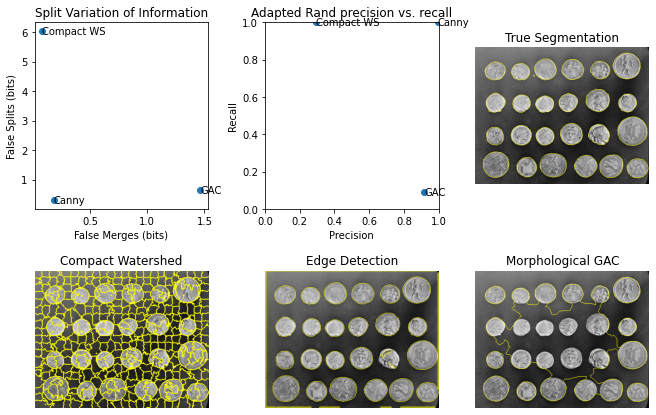

In [6]:
image = img_as_float(image)
gradient = inverse_gaussian_gradient(image)
init_ls = np.zeros(image.shape, dtype=np.int8)
init_ls[10:-10, 10:-10] = 1
im_test3 = morphological_geodesic_active_contour(gradient, num_iter=100,
                                                 init_level_set=init_ls,
                                                 smoothing=1, balloon=-1,
                                                 threshold=0.69)
im_test3 = label(im_test3)

method_names = ['Compact watershed', 'Canny filter',
                'Morphological Geodesic Active Contours']
short_method_names = ['Compact WS', 'Canny', 'GAC']

precision_list = []
recall_list = []
split_list = []
merge_list = []
for name, im_test in zip(method_names, [im_test1, im_test2, im_test3]):
    error, precision, recall = adapted_rand_error(im_true, im_test)
    splits, merges = variation_of_information(im_true, im_test)
    split_list.append(splits)
    merge_list.append(merges)
    precision_list.append(precision)
    recall_list.append(recall)
    print(f'\n## Method: {name}')
    print(f'Adapted Rand error: {error}')
    print(f'Adapted Rand precision: {precision}')
    print(f'Adapted Rand recall: {recall}')
    print(f'False Splits: {splits}')
    print(f'False Merges: {merges}')

fig, axes = plt.subplots(2, 3, figsize=(9, 6), constrained_layout=True)
ax = axes.ravel()

ax[0].scatter(merge_list, split_list)
for i, txt in enumerate(short_method_names):
    ax[0].annotate(txt, (merge_list[i], split_list[i]),
                   verticalalignment='center')
ax[0].set_xlabel('False Merges (bits)')
ax[0].set_ylabel('False Splits (bits)')
ax[0].set_title('Split Variation of Information')

ax[1].scatter(precision_list, recall_list)
for i, txt in enumerate(short_method_names):
    ax[1].annotate(txt, (precision_list[i], recall_list[i]),
                   verticalalignment='center')
ax[1].set_xlabel('Precision')
ax[1].set_ylabel('Recall')
ax[1].set_title('Adapted Rand precision vs. recall')
ax[1].set_xlim(0, 1)
ax[1].set_ylim(0, 1)

ax[2].imshow(mark_boundaries(image, im_true))
ax[2].set_title('True Segmentation')
ax[2].set_axis_off()

ax[3].imshow(mark_boundaries(image, im_test1))
ax[3].set_title('Compact Watershed')
ax[3].set_axis_off()

ax[4].imshow(mark_boundaries(image, im_test2))
ax[4].set_title('Edge Detection')
ax[4].set_axis_off()

ax[5].imshow(mark_boundaries(image, im_test3))
ax[5].set_title('Morphological GAC')
ax[5].set_axis_off()

plt.show()